In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom, multinomial
from tqdm import tqdm

from combinations import combinations_

In [4]:
def get_configuration_chart(vertex_states, kappa):
    '''
    Given the number of vertex-edge states, output all the unique configurations they can be
    in (Balls and bins problem)
    '''
    return np.array(combinations_(kappa, vertex_states))

print(f'C={get_configuration_chart(4, 2)}')

def eta(kappa):
    '''
    Generate a Bernoulli(1/2) distribution on vertices and edges
    '''
    conf_chart = get_configuration_chart(4, kappa)
    return np.vstack([multinomial.pmf(conf_chart, n=kappa, p=[1/4] * 4)/2] * 2)

def Hamiltonian(beta, B, C):
    '''
    Generate hamiltonian values corresponding to all unique states
    '''
    vertex_spin_sum = C[:, 0] - C[:, 1] - C[:, 2] + C[:, 3]
    return np.vstack([-beta / 2 * vertex_spin_sum - B,
                      beta / 2 * vertex_spin_sum + B])

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa, counts):
    '''
    Joint distribution for a randomly-chosen edge 
    '''
    # return p @ counts / kappa
    # Equivalent to p @ counts / kappa, but y_0v and x_v are different axes 
    return np.stack([p @ counts[:, :2], p @ counts[:, 2:]], axis=1) / kappa

def multinomial_coeff(params):
    '''
    Calculate the multinomial coefficient
    
    Inputs:
    params: a list, [x1, x2, ..., xk]
    
    Outputs:
    multinomial coefficient {x1 + x2 + ... + xk \choose x1 x2 ... xk}
    '''
    if len(params) == 1:
        return 1
    return scipy.special.binom(sum(params), params[-1]) * multinomial_coeff(params[:-1])

def vertex_distribution(p, kappa, C):
    '''
    Joint distribution for all edge-vertex pairs
    
    Input:
    p: 1-d array representing distribution on leaf configurations
    
    Output:
    kappa-d array representing the joint distribution of all edge-vertex pairs
    '''
    # Get the equivalent configuration for each combined vertex-edge state
    def counts(*vertex_marks):
        stacked = np.stack(vertex_marks, axis=0)
        ks = [np.count_nonzero(stacked == l, axis=0) for l in range(4)]
        return np.stack(ks, axis=-1)
    ks = np.fromfunction(counts, [4] * kappa)
    
    # Match the configurations with the ones from configurations list
    k_reshaped = ks.reshape((-1, 4))
    indices = [(conf == C).all(axis=-1).nonzero()[0][0] for conf in k_reshaped]
    
    # Calculate probabilities for each one
    probabilities = [p[index] / multinomial_coeff(C[index]) for index in indices]
    
    return np.array(probabilities).reshape((4,) * kappa)

def objective_function(mu, beta, B, kappa, C):
    eta_dist = eta(kappa=kappa)
    hamiltonian = Hamiltonian(beta=beta, B=B, C=C)
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta_dist)
    pi_mu = edge_distribution(mu, kappa=kappa, counts=C)
    pi_eta = edge_distribution(eta_dist, kappa=kappa, counts=C)
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr

C = get_configuration_chart(4, 2)
print(f'{eta(2)=}')
print(f'{edge_distribution(eta(2), kappa=2, counts=C)=}')
print(f'{Hamiltonian(1, 0, C)=}')
ver_dist = vertex_distribution(np.sum(eta(kappa=2), axis=0), kappa=2, C=C)
print(f'{ver_dist=}')
print(f'{np.sum(ver_dist)=}')

C=[[0 0 0 2]
 [0 0 1 1]
 [0 0 2 0]
 [0 1 0 1]
 [0 1 1 0]
 [1 0 0 1]
 [1 0 1 0]
 [0 2 0 0]
 [1 1 0 0]
 [2 0 0 0]]
eta(2)=array([[0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125],
       [0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125]])
edge_distribution(eta(2), kappa=2, counts=C)=array([[[0.125, 0.125],
        [0.125, 0.125]],

       [[0.125, 0.125],
        [0.125, 0.125]]])
Hamiltonian(1, 0, C)=array([[-1., -0.,  1., -0.,  1., -1., -0.,  1., -0., -1.],
       [ 1.,  0., -1.,  0., -1.,  1.,  0., -1.,  0.,  1.]])
ver_dist=array([[0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625]])
np.sum(ver_dist)=1.0


In [59]:
def optimize(beta, B, kappa, mu0=None, C=None, verbose=False, ftol=1e-9, max_iter=1000, project_mu0=False):
    if C is None:
        C = get_configuration_chart(4, kappa)
    if verbose:
        # print(f'{C=}')
        pass
    num_configurations = len(C)
    
    eta_dist = eta(kappa=kappa)
    bounds = Bounds(np.zeros_like(eta_dist.flatten()), np.ones_like(eta_dist.flatten()), keep_feasible=True)
    norm_constraint = LinearConstraint(np.ones_like(eta_dist.flatten()), 1, 1, keep_feasible=True)
    admissibility_linear = np.block([[C[:, 1], -C[:, 0]],
                                    [C[:, 3], -C[:, 2]]]) / kappa
    admissibility_constraint = LinearConstraint(admissibility_linear, lb=0, ub=0, keep_feasible=True)
    
    if mu0 is None:
        mu0 = np.random.uniform(-1, 1, size=eta_dist.shape)
        mu0 = mu0 / np.sum(mu0)
        # Project onto the closest point on the probability simplex
        if project_mu0:
            res = minimize(lambda mu: np.sum((mu - mu0.flatten())** 2) / 2, x0=mu0.flatten(), 
                        method='trust-constr', 
                        constraints=[norm_constraint, admissibility_constraint], 
                        bounds=bounds)
            mu0 = res.x.reshape(2, -1)
    
    if verbose:
        print(f'{beta=}, {B=}, {kappa=}\n{mu0=}\n{np.sum(mu0)=}')
    
    res = minimize(lambda mu: -objective_function(mu.reshape(2, num_configurations), beta=beta, B=B, kappa=kappa, C=C),
                   x0=mu0.flatten(), method='SLSQP', 
                   constraints=[norm_constraint, admissibility_constraint],
                   bounds=bounds,
                   options={'ftol': ftol, 'disp': verbose, 'maxiter': max_iter})
    
    mu = res.x.reshape(2, num_configurations)
    
    if verbose:
        print(f'{objective_function(mu, beta=beta, B=B, kappa=kappa, C=C)=}\n')
        print(f'{mu=}\n\n{np.sum(mu)=}\n\n edge_distribution={edge_distribution(mu, kappa=kappa, counts=C)}')
    
    return mu

In [54]:
mu = optimize(beta=1, B=1, kappa=6, verbose=True)

beta=1, B=1, kappa=6
mu0=array([[-0.01151076,  0.02029927, -0.07436844, -0.02609722,  0.07096563,
         0.0368638 ,  0.06217617, -0.12029325,  0.0310463 ,  0.12778106,
        -0.08333158, -0.12733749,  0.06339422,  0.10945665,  0.05008077,
         0.00765403, -0.07430917,  0.06887046,  0.02961521,  0.1186642 ,
        -0.10148481,  0.09079744, -0.0625937 , -0.1022103 , -0.03474952,
         0.05180422, -0.10535793, -0.04581499,  0.1198129 ,  0.06530806,
         0.07726151,  0.12136852,  0.11426926, -0.03995587,  0.04998773,
         0.04217219, -0.03914447, -0.02902483,  0.06413477, -0.00355362,
         0.02865103, -0.08716941, -0.11766419, -0.10204359, -0.08749301,
        -0.02854194, -0.09559524,  0.05665816, -0.10285513,  0.00532102,
        -0.10155264,  0.04097362,  0.09815056, -0.09230899,  0.06942951,
         0.00615558,  0.03218668,  0.09023734, -0.07034549,  0.0842903 ,
        -0.09584056, -0.03788991,  0.06286736, -0.08307774, -0.0866732 ,
        -0.07709937,  0.08

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.7351232932440137
            Iterations: 261
            Function evaluations: 44750
            Gradient evaluations: 261
objective_function(mu, beta=beta, B=B, kappa=kappa, C=C)=1.7351232932440137

mu=array([[1.51202418e-07, 9.52592086e-07, 2.38440210e-06, 3.15810869e-06,
        2.41858575e-06, 9.49955363e-07, 1.59323498e-07, 7.08213773e-06,
        3.54112404e-05, 7.07372649e-05, 7.07194527e-05, 3.54245681e-05,
        7.05729350e-06, 1.27841758e-07, 6.43481933e-07, 1.27986521e-06,
        1.29866437e-06, 6.47270466e-07, 1.25690446e-07, 1.30894441e-04,
        5.23054380e-04, 7.84543060e-04, 5.23082919e-04, 1.30740816e-04,
        4.77713830e-06, 1.91275618e-05, 2.87414705e-05, 1.91423537e-05,
        4.77693266e-06, 4.54681737e-08, 1.75272106e-07, 2.63046581e-07,
        1.71373429e-07, 4.43153280e-08, 1.28826171e-03, 3.86494947e-03,
        3.86535561e-03, 1.28835662e-03, 7.07338735e-05, 

### P(X1, X2 | X0)

In [180]:
C = get_configuration_chart(4, 2)

mu = optimize(beta=1, B=0, kappa=2, ftol=1e-10)

x0 = 0
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = vertex_distribution(mu_edge, kappa=2, C=C)
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


mu_edge=array([0.00355234, 0.05249689, 0.19395088, 0.05249677, 0.38790176,
       0.0071047 , 0.05249682, 0.19395071, 0.05249676, 0.00355238])
leaf_dist=array([[0.00355238, 0.02624838, 0.02624841, 0.00355235],
       [0.02624838, 0.19395071, 0.19395088, 0.02624838],
       [0.02624841, 0.19395088, 0.19395088, 0.02624845],
       [0.00355235, 0.02624838, 0.02624845, 0.00355234]])
p_x1=array([0.05960151, 0.44039835, 0.44039861, 0.05960152]) p_x2=array([0.05960151, 0.44039835, 0.44039861, 0.05960152])
np.outer(p_x1, p_x2)=array([[0.00355234, 0.02624841, 0.02624842, 0.00355234],
       [0.02624841, 0.19395071, 0.19395082, 0.02624841],
       [0.02624842, 0.19395082, 0.19395094, 0.02624843],
       [0.00355234, 0.02624841, 0.02624843, 0.00355234]])


/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


(-0.01, 0.11)

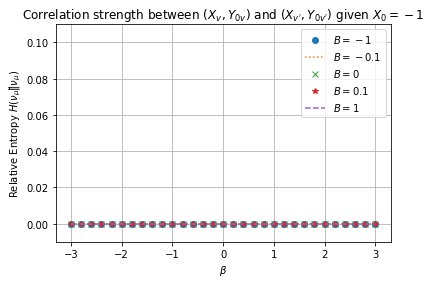

In [60]:
betas = np.linspace(-3, 3, 31)
pearson_coeff = []
Bs = [-1, -0.1, 0, .1, 1]
kappa = 2
C = get_configuration_chart(4, kappa)

x0 = 0

for B, m in zip(Bs, ['o', ':', 'x', '*', '--']):
    frob_dists = []

    for beta in betas:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10, C=C)

        mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
        
        leaf_dist = vertex_distribution(mu_edge, kappa=2, C=C)
        
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)

        
        frob_dists.append(relative_entropy(leaf_dist, indep_dist))
        
    frob_dists = np.array(frob_dists)

    plt.plot(betas, frob_dists, m, label=f'${B=}$')

plt.legend()
plt.title(f'Correlation strength between $(X_v, Y_{{0v}})$ and $(X_{{v\'}}, Y_{{0v\'}})$ given $X_0={2*x0-1}$')
plt.xlabel('$\\beta$')
plt.ylabel('Relative Entropy $H(\\nu_\mu \| \check{\\nu}_\mu)$')
plt.grid(True)

plt.ylim((-.01, 0.11))

# plt.savefig(f'../img/EA_x1_x2_RelEntr_x0={2*x0-1}.png')

### P(X0) with respect to B

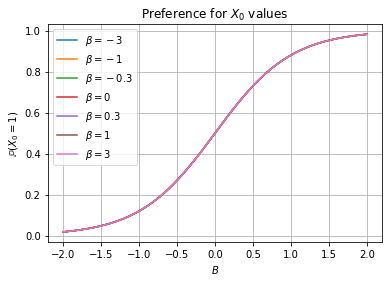

In [61]:
Bs = np.linspace(-2, 2, 51)
betas = [-3, -1, -0.3, 0, 0.3, 1, 3]

for beta in betas:
    probabilities = []
    for B in Bs:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    plt.plot(Bs, probabilities, label=f'$\\beta={beta}$')
plt.title('Preference for $X_0$ values')
plt.xlabel('$B$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B.png')

Assume that we have the form
$$\mu(x_0, \tau) = e^{\mathcal{H(x_0, \tau)}}$$
I am guessing that
$$\mu_0(x_0) = \frac1Ze^{f(\beta, B)x_0}$$
Therefore, plotting
$$\log\frac{\mu_0(+)}{1-\mu_0(+)}$$
sounds like a good idea

In [64]:
Bs = np.linspace(-2, 2, 31)
kappa = 3
betas = [-1, -0.3, 0, 0.3, 1]

res = []

for beta, m in zip(betas, ['o', ':', 'x', '*', '--']):
    probabilities = []
    for B in tqdm(Bs):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
    
    res.append(np.array(probabilities))

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


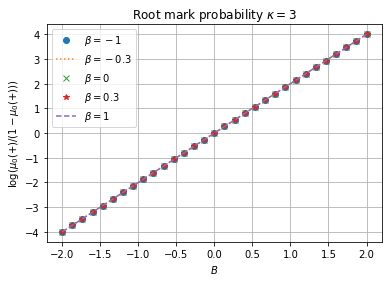

In [65]:
for probabilities, beta, m in zip(res, betas, ['o', ':', 'x', '*', '--']):
    plt.plot(Bs, np.log(probabilities / (1 - probabilities)), m, label=f'$\\beta={beta}$')

plt.title(f'Root mark probability $\\kappa={kappa}$')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig(f'../img/EA_x0_B_logisitic_kappa_{kappa}.png')

#### Different $\kappa$ values

In [143]:
kappa = 6
B = 2
C = get_configuration_chart(4, kappa=kappa)
mu = optimize(beta=beta, B=B, kappa=kappa, C=C, ftol=1e-10, verbose=True)

C=array([[0, 0, 0, 6],
       [0, 0, 1, 5],
       [0, 0, 2, 4],
       [0, 0, 3, 3],
       [0, 0, 4, 2],
       [0, 0, 5, 1],
       [0, 0, 6, 0],
       [0, 1, 0, 5],
       [0, 1, 1, 4],
       [0, 1, 2, 3],
       [0, 1, 3, 2],
       [0, 1, 4, 1],
       [0, 1, 5, 0],
       [1, 0, 0, 5],
       [1, 0, 1, 4],
       [1, 0, 2, 3],
       [1, 0, 3, 2],
       [1, 0, 4, 1],
       [1, 0, 5, 0],
       [0, 2, 0, 4],
       [0, 2, 1, 3],
       [0, 2, 2, 2],
       [0, 2, 3, 1],
       [0, 2, 4, 0],
       [1, 1, 0, 4],
       [1, 1, 1, 3],
       [1, 1, 2, 2],
       [1, 1, 3, 1],
       [1, 1, 4, 0],
       [2, 0, 0, 4],
       [2, 0, 1, 3],
       [2, 0, 2, 2],
       [2, 0, 3, 1],
       [2, 0, 4, 0],
       [0, 3, 0, 3],
       [0, 3, 1, 2],
       [0, 3, 2, 1],
       [0, 3, 3, 0],
       [1, 2, 0, 3],
       [1, 2, 1, 2],
       [1, 2, 2, 1],
       [1, 2, 3, 0],
       [2, 1, 0, 3],
       [2, 1, 1, 2],
       [2, 1, 2, 1],
       [2, 1, 3, 0],
       [3, 0, 0, 3],
       [3, 

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


Iteration limit reached    (Exit mode 9)
            Current function value: -2.6105165493722495
            Iterations: 100
            Function evaluations: 17347
            Gradient evaluations: 100
objective_function(mu, beta=beta, B=B, kappa=kappa, C=C)=2.6105165493722495

mu=array([[4.30172832e-05, 1.85397466e-07, 2.39811504e-06, 3.19520695e-06,
        6.65701751e-06, 1.28296014e-08, 9.58133810e-09, 1.61135813e-05,
        2.76854463e-05, 6.07518560e-06, 9.16484984e-08, 2.76712122e-07,
        1.60204633e-06, 2.94691440e-06, 8.33536504e-07, 5.93769665e-06,
        1.54181612e-05, 5.57954744e-09, 4.18739704e-09, 1.03412352e-04,
        1.90495315e-04, 9.60875021e-05, 7.19344888e-06, 4.09405332e-06,
        5.55888049e-06, 1.13484307e-06, 1.18294163e-06, 5.88666508e-06,
        4.95041732e-06, 1.76974684e-07, 8.02948746e-07, 3.91883753e-07,
        8.75901297e-09, 4.24539354e-12, 1.00269057e-03, 9.45989248e-04,
        2.73175881e-04, 4.92372454e-05, 3.35471835e-05, 3.48754146e-0

In [145]:
np.min(mu)

2.4292078230762447e-12

In [139]:
Bs = np.linspace(-2, 2, 31)
kappas = [2, 3, 4, 5, 6]
beta = 1

res = []
for kappa, m in zip(kappas, ['o', ':', 'x', '*', '--']):
    probabilities = []
    for B in tqdm(Bs):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    res.append(probabilities)

100%|██████████| 31/31 [04:39<00:00,  9.02s/it]


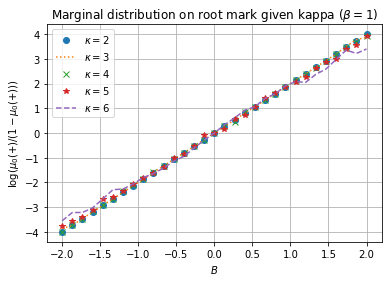

In [146]:
for probabilities, kappa, m in zip(res, kappas, ['o', ':', 'x', '*', '--']):
    probabilities = np.array(probabilities)
    plt.plot(Bs, np.log(probabilities / (1 - probabilities)), m, label=f'$\\kappa={kappa}$')

plt.title(f'Marginal distribution on root mark given kappa ($\\beta={beta}$)')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B_logisitic_change_kappa.png')

In [66]:
A = np.eye(3)
b = np.arange(3)
A + b

array([[1., 1., 2.],
       [0., 2., 2.],
       [0., 1., 3.]])